In [6]:
import casadi as ca
import numpy as np
import control
import matplotlib.pyplot as plt

from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

# make matrix printing prettier
np.set_printoptions(precision=3, suppress=True)

This notebook will walk through trimming and control design for a transport aircxraft using casadi.

In [7]:
def rhs(x, u):
    s = 2170
    cbar = 17.5
    mass = 5.0e3
    iyy = 4.1e6
    tstat = 6.0e4
    dtdv = -38.0
    ze = 0.0
    cdcls = 0.042
    cla = 0.085
    cma = -0.022
    cmde = -0.016
    cmq = -16.0
    cmadot = -6.0
    cladot = 0.0
    rtod = 57.29578
    gd = 32.17
    
    thtl = u[0]
    elev_deg = u[1]
    xcg = u[2]
    land = u[3]
    
    vt = x[0]  # velocity, ft/s
    alpha = x[1]
    alpha_deg = rtod*alpha  # angle of attack, deg
    theta = x[2]  # pitch angle, rad
    q = x[3]  # pitch rate, rad/s
    h = x[4]  # altitude, ft
    pos = x[5]  # horizontal position from origin, ft (not used in dynamics)
    
    r0 = 2.377e-3
    tfac = 1.0 - 0.703e-5*h
    temperature = ca.if_else(h > 35000, 390.0, 519.0*tfac)
    rho = r0*(tfac**4.14)
    mach = vt/ca.sqrt(1.4*1716.3*temperature)
    qbar = 0.5*rho*vt**2
    
    qs = qbar*s
    salp = ca.sin(alpha)
    calp = ca.cos(alpha)
    gam = theta - alpha
    sgam = ca.sin(gam)
    cgam = ca.cos(gam)
    
    aero_p = ca.if_else(
        land,
        (1.0, 0.08, -0.20, 0.02, -0.05),
        (0.2, 0.016, 0.05, 0.0, 0.0))
    cl0 = aero_p[0]
    cd0 = aero_p[1]
    cm0 = aero_p[2]
    dcdg = aero_p[3]
    dcmg = aero_p[4]
    
    thr = (tstat + vt*dtdv)*ca.fmax(thtl, 0)
    cl = cl0 + cla*alpha_deg
    cm = dcmg + cm0 + cma*alpha_deg + cmde*elev_deg + cl*(xcg - 0.25)
    cd = dcdg + cd0 + cdcls*cl**2
    
    x_dot = ca.SX.zeros(6)
    x_dot[0] = (thr*calp - qs*cd)/mass - gd*sgam
    x_dot[1] = (-thr*salp - qs*cl + mass*(vt*q + gd*cgam))/(mass*vt + qs*cladot)
    x_dot[2] = q
    d = 0.5*cbar*(cmq*q + cmadot*x_dot[1])/vt
    x_dot[3] = (qs*cbar*(cm + d) + thr*ze)/iyy
    x_dot[4] = vt*sgam
    x_dot[5] = vt*cgam
    return x_dot

In [8]:
def constrain(s, vt, h, q, gamma):
    
    # s is our design vector:
    # s = [thtl, elev_deg, alpha]
    thtl = s[0]
    elev_deg = s[1]
    alpha = s[2]
    
    pos = 0  # we don't care what horiz. position we are at
    xcg = 0.25  # we assume xcg at 1/4 chord
    land = 0  # we assume we do not have flaps/gear deployed
    theta = alpha + gamma
    
    # vt, alpha, theta, q, h, pos
    x = ca.vertcat(vt, alpha, theta, q, h, pos)
    
    # thtl, elev_deg, xcg, land
    u = ca.vertcat(thtl, elev_deg, xcg, land)
    return x, u

def trim_cost(x, u):
    x_dot = rhs(x, u)
    return x_dot[0]**2 + 100*x_dot[1]**2 + 10*x_dot[3]**2

def objective(s, vt, h, q, gamma):
    x, u = constrain(s, vt, h, q, gamma)
    return trim_cost(x, u)

In [9]:
def trim(vt, h, q, gamma):
    s = ca.SX.sym('s', 3)
    nlp = {'x': s, 'f': objective(s, vt=vt, h=h, q=q, gamma=gamma)}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    # s = [thtl, elev_deg, alpha]
    s0 = [0.293, 2.46, np.deg2rad(0.58)]
    res = S(x0=s0, lbg=0, ubg=0, lbx=[0, -60, -np.deg2rad(5)], ubx=[1, 60, np.deg2rad(18)])
    trim_cost = res['f']
    trim_tol = 1e-10
    if trim_cost > trim_tol:
        raise ValueError('Trim failed to converge', trim_cost)
    assert np.abs(float(res['f'])) < trim_tol
    s_opt = res['x']
    x0, u0 = constrain(s_opt, vt, h, q, gamma)
    return {
        'x0': np.array(x0).reshape(-1),
        'u0': np.array(u0).reshape(-1),
        's': np.array(s_opt).reshape(-1)
    }

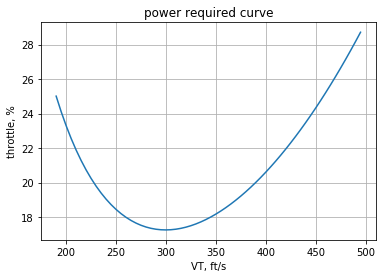

In [10]:
def power_required_curve():
    throttle = []
    vt_list = np.arange(190, 500, 5)
    for vt in vt_list:
        res = trim(vt=vt, h=0, q=0, gamma=0)
        throttle.append(res['s'][0])
    plt.plot(vt_list, 100*np.array(throttle))
    plt.grid()
    plt.ylabel(r'throttle, %')
    plt.xlabel('VT, ft/s')
    plt.title('power required curve')
    
power_required_curve()

In [11]:
def linearize(trim):
    x0 = trim['x0']
    u0 = trim['u0']
    x = ca.SX.sym('x', 6)
    u = ca.SX.sym('u', 4)
    y = x
    A = ca.jacobian(rhs(x, u), x)
    B = ca.jacobian(rhs(x, u), u)
    C = ca.jacobian(y, x)
    D = ca.jacobian(y, u)
    f_ss = ca.Function('ss', [x, u], [A, B, C, D])
    return control.ss(*f_ss(x0, u0))

In [12]:
def pitch_rate_control_design(vt, H, xlim, ylim, tf=3):
    trim_state = trim(vt=vt, h=0, q=0, gamma=0)
    print(trim_state)
    sys = linearize(trim_state)
    G = control.minreal(control.tf(sys[3, 1]), 1e-2)
    control.rlocus(G*H, kvect=np.linspace(0, 1, 1000), xlim=xlim, ylim=ylim);
    Go = G*H
    Gc = control.feedback(Go)
    plt.plot([0, -3], [0, 3*np.arccos(0.707)], '--')
    #plt.axis('equal')
    plt.grid()
    
    plt.figure()
    control.bode(Go, margins=True, dB=True, Hz=True, omega_limits=[1e-2, 1e2], omega_num=1000);
    plt.grid()

    plt.figure()
    t = np.linspace(0, tf, 1000)
    r = np.array(t > 0.1, dtype=float)
    t, y, x = control.forced_response(Gc, T=t, U=r)
    _, u, _ = control.forced_response((1/G)*Gc, T=t, U=r)

    u_norm = np.abs(u)
    max_u_norm = np.max(u_norm)
    print('u_norm max', max_u_norm)

    plt.plot(t, y, label='x')
    plt.plot(t, r, label='r')
    plt.plot(t, u_norm/max_u_norm, label='u normalized')
    plt.gca().set_ylim(0, 1.5)
    plt.grid()
    plt.legend()

{'x0': array([500.  ,   0.01,   0.01,   0.  ,   0.  ,   0.  ]), 'u0': array([0.293, 2.328, 0.25 , 0.   ]), 's': array([0.293, 2.328, 0.01 ])}
1 states have been removed from the model


/home/kevin/anaconda3/envs/aae497-f19/lib/python3.7/site-packages/control/xferfcn.py:896: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, np + 1 - len(numpoly):np + 1] = numpoly[::-1]


u_norm max 853.5644468055459


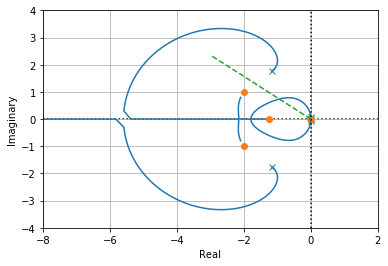

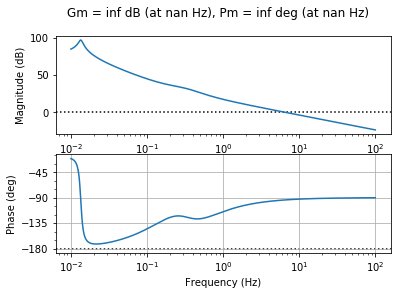

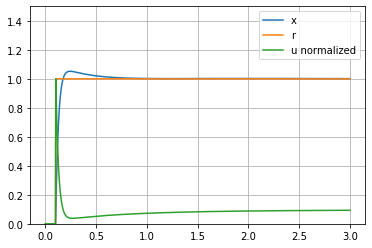

In [13]:
s = control.tf([1, 0], [0, 1])
# this is a PID controller with an extra pole at the origin
pitch_rate_control_design(500, -900*((s + 2 + 1j)*(s + 2 - 1j)/s**2), [-8, 2], [-4, 4])

{'x0': array([200.   ,   0.273,   0.273,   0.   ,   0.   ,   0.   ]), 'u0': array([  0.233, -18.347,   0.25 ,   0.   ]), 's': array([  0.233, -18.347,   0.273])}
1 states have been removed from the model
u_norm max 990.9811402584778


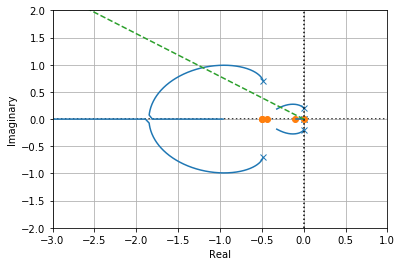

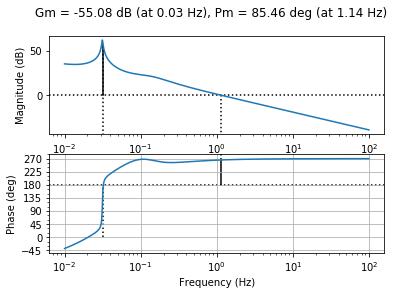

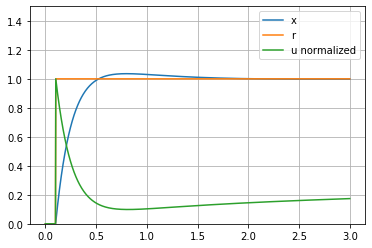

In [14]:
pitch_rate_control_design(200, -1000*((s+0.5)/s)**2, [-3, 1], [-2, 2])

In [15]:
def lqr_design(out_num, in_num, tf=3, R=1e-5, y_max=1.5):
    trim_500 = trim(vt=500, h=0, q=0, gamma=0)
    # input: thtl, elev, xcg, land
    # state: vt, alpha, theta, q, h, pos
    sys = control.minreal(linearize(trim_500)[out_num, in_num], 1e-3)
    assert np.linalg.matrix_rank(control.ctrb(sys.A, sys.B)) == sys.A.shape[0]
    assert np.linalg.matrix_rank(control.obsv(sys.A, sys.C)) == sys.A.shape[0]

    Q = sys.C.T.dot(sys.C)
    K, S, E = control.lqr(sys, Q, R)
    sys_c = control.ss( sys.A - sys.B*K, sys.B, sys.C, sys.D)
    final_value = float(sys_c.horner(0))
    N = 1.0/final_value
    sys_c = control.ss( sys.A - sys.B*K, sys.B*N, sys.C, sys.D)

    t = np.linspace(0, tf, 1000)
    r = np.array(t > 0.1, dtype=float)
    t, y, x = control.forced_response(sys_c, T=np.linspace(0, tf, 1000), U=r)
    u_norm = np.linalg.norm(K.dot(x), axis=0)
    max_u_norm = np.max(u_norm)
    print('u_norm max', max_u_norm)

    plt.plot(t, r, 'r--', label='r')
    plt.plot(t, y, 'b-', label='y')
    plt.plot(t, u_norm/max_u_norm, 'g-', label='u normalized')
    plt.gca().set_ylim(-0.1, y_max)
    plt.grid()
    plt.legend()

1 states have been removed from the model
u_norm max 324.1938796680499


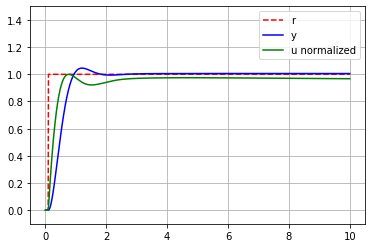

In [16]:
lqr_design(2, 1, tf=10, R=1e-5)

Here we see that the LQR is not able to design a reasonable pitch rate controller.

1 states have been removed from the model
u_norm max 63670.60717497369


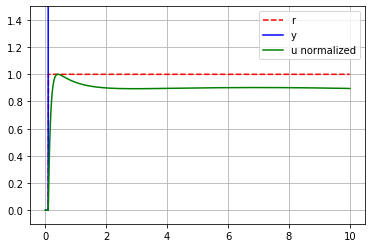

In [17]:
lqr_design(3, 1, tf=10, R=1e-5, y_max=1.5)

Here we see the LQR is doing a poor job of designing a pitch rate controller. This is likely because none of the
states provide derivative of the pitch rate signal to prevent overshoot.